The goal of this tutorial will be to explain 2D Gaussian processes (GPs) and the optimisations implemented in luas to calculate the log-likelihood as well as the GP predictive mean and covariance. Gradients of the log-likelihood are not covered in this tutorial but are implemented in the tutorial using JAX in another notebook.

Let's start off with what is a Gaussian process. When we model noise in a given data set as a Gaussian process, we are assuming that if we take any two datapoints $x_i$ and $x_j$ from the data set, then the covariance between these two points is given by some kernel function. In the simplest case of white noise, our kernel function can be expressed as:

\begin{equation}
    k(x_i, x_j) = \sigma^2 \delta_{ij}
\end{equation}

Where $k$ is our kernel function, $\sigma$ is the amplitude of white noise and $\delta$ is the kronecker delta symbol which equals one when $i = j$ and zero when $i \neq j$. Note that this results in each new point being completely independent from the last point. The only correlations are when a point is trivially correlated with itself.

Within astronomy we often encounter correlated noise, this is where different points are correlated which may be separated in time or some other dimension(s). A common way of modelling this is to choose a squared-exponential kernel, which assumes that the strength of the correlation tails off as the separation between two points increases:

\begin{equation}
    k(t_i, t_j) = h^2 \exp\left(-\frac{|t_i - t_j|^2}{2 l_\mathrm{t}^2}\right) + \sigma^2 \delta_{ij}
\end{equation}

Here we have assumed our data varies in time and are considering the covariance between two points in time $t_i$ and $t_j$. We have kept the white noise term but have added $h$ for the height scale (or amplitude) of the correlated noise and $l_t$ is our length scale in time which describes over what timescale the correlation tails off over. Notice how the further the separation between $t_i$ and $t_j$, the lower the covariance.

Let's start by generating noise from these two kernel functions to get an idea of what type of noise they describe:

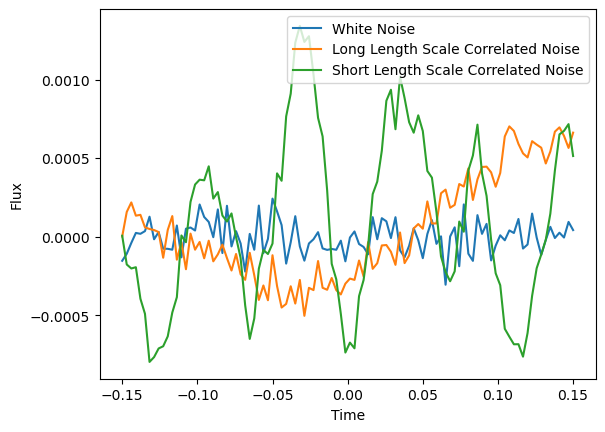

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def kf(x1, x2, hp, wn=True):
    """
    Squared exponential kernel function.

    x1 - first vector of inputs
    x2 - second vector of inputs
    p = [height scale, length scale, white noise]

    """
    D = np.subtract.outer(x1/hp[1],x2/hp[1]) # delta x/l array
    D2 = np.square(D) #delta x squared
    K = hp[0]**2 * np.exp(-0.5*D2) #compute kernel
    
    if wn == True:
        np.fill_diagonal(K,hp[0]**2+hp[2]**2) #add white noise to the diagonal
        
    return K

N_t = 100 # Number of time points
x_t = np.linspace(-0.15, 0.15, N_t) # Timestamps for our synthetic observations

fig = plt.figure()

# Generate white noise covariance matrix
K_wn = 1e-4**2*np.eye(N_t)
r = np.random.multivariate_normal(np.zeros(N_t), K_wn)
plt.plot(x_t, r, '-', label = "White Noise")

# An example with a reasonably long length scale
K_t = kf(x_t, x_t, [5e-4, 0.1, 1e-4], wn=True)
r = np.random.multivariate_normal(np.zeros(N_t), K_t)
plt.plot(x_t, r, '-', label = "Long Length Scale Correlated Noise")

# An example with a shorter length scale
K_t = kf(x_t, x_t, [5e-4, 0.01, 1e-4], wn=True)
r = np.random.multivariate_normal(np.zeros(N_t), K_t)
plt.plot(x_t, r, '-', label = "Short Length Scale Correlated Noise")

plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.show()

To use a GP to fit data we typically we need to use the log-likelihood function as a metric for how well our model fits the data. The log-likelihood function for a Gaussian process is given as:

\begin{equation}
        \log L = -\frac{1}{2}\vec{r}^T \mathbf{K}^{-1} \vec{r} - \frac{1}{2}\log|\mathbf{K}| - \frac{N}{2}\log(2\pi)
\end{equation}

Where $\vec{r}$ is the residuals of the observations minus our model, $\mathbf{K}$ is our covariance matrix and $N$ is the number of datapoints.

Let's calculate this for a random draw of correlated noise:

In [2]:
from scipy.linalg import cho_factor, cho_solve

# Generate a random draw of noise from the matrix K_t
K_t = kf(x_t, x_t, [5e-4, 0.01, 1e-4], wn=True)
r = np.random.multivariate_normal(np.zeros(N_t), K_t)

def logL_cholesky(r,K):
    
    # Use cholesky factorisation to solve for K^-1 x r and get log determinant of K
    choF = cho_factor(K,check_finite=False)
    logdetK = 2*np.log(np.diag(choF[0])).sum()
    
    #compute the log Likelihood
    r_K_inv_r = np.dot(r,cho_solve(choF,r,check_finite=False))
    logL = -0.5 * r_K_inv_r - 0.5 * logdetK  - 0.5*r.size*np.log(2*np.pi)
    
    return logL

logL_cholesky(r, K_t)

716.482860376863

Now let's do the same thing for two-dimensional data! Let's consider flux observations in both wavelength and time. We can choose to use a squared-exponential kernel to account for correlations that may exist across each dimension. We will write this kernel function as:

\begin{equation}
    k((\lambda_i, t_i), (\lambda_j, t_j)) = h^2 \exp\left(-\frac{|\lambda_i - \lambda_j|^2}{2 l_\mathrm{\lambda}^2}\right) \exp\left(-\frac{|t_i - t_j|^2}{2 l_\mathrm{t}^2}\right) + \sigma^2 \delta_{ij}
\end{equation}

Note that this can be written as separate wavelength and time kernel functions multiplied together plus a constant white noise term:

\begin{equation}
    k((\lambda_i, t_i), (\lambda_j, t_j)) = k_\mathrm{\lambda}(\lambda_i, \lambda_j) k_\mathrm{t}(t_i, t_j) + \sigma^2 \delta_{ij}
\end{equation}

Where:
\begin{align}
    k_\mathrm{\lambda}(\lambda_i, \lambda_j) &= h^2 \exp\left(-\frac{|\lambda_i - \lambda_j|^2}{2 l_\mathrm{\lambda}^2}\right) \\
    k_\mathrm{t}(t_i, t_j) &= \exp\left(-\frac{|t_i - t_j|^2}{2 l_\mathrm{t}^2}\right)
\end{align}

If we can assume that our data lies on the wavelength by time grid (i.e. we choose the same wavelength bands for all points in time), we can fully separate calculating the kernel in wavelength and time by building separate $\mathbf{K}_\mathrm{\lambda}$ and $\mathbf{K}_\mathrm{t}$ covariance matrices describing the covariance in wavelength and time. We then need to multiply the covariance due to each wavelength separation by the covariance due to every time separation. We can represent this with a kronecker product (denoted as $\otimes$). This allows us to write our full covariance matrix $\mathbf{K}$ as:

\begin{equation}
    \mathbf{K} = \mathbf{K}_\mathrm{\lambda} \otimes \mathbf{K}_\mathrm{t} + \sigma^2 \mathbb{I}
\end{equation}

We can generate noise using this covariance matrix with the following code (a more optimised method will also be described later):

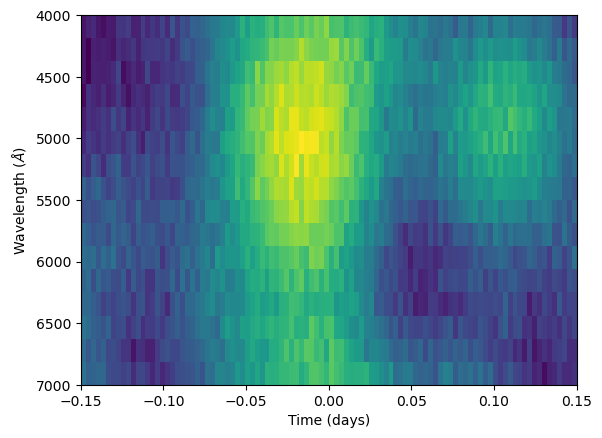

In [3]:
N_l = 16  # Number of wavelength points
N_t = 100 # Number of time points

x_l = np.linspace(4000, 7000, 16)   # Centre of wavelength channels 
x_t = np.linspace(-0.15, 0.15, N_t) # Timestamps for our synthetic observations

# Set hyperparameters (try modifying to see the effect on noise)
h = 5e-4
l_l = 1000
l_t = 0.04
sigma = 1e-4

# Build separate wavelength and time covariance matrices
K_l = kf(x_l, x_l, [h, l_l], wn=False)
K_t = kf(x_t, x_t, [1., l_t], wn=False)

# Build "full" covariance matrix (memory intensive for large data sets)
K_2D = np.kron(K_l, K_t) + sigma**2 * np.eye(N_l*N_t)

# Generate a random draw of noise from this matrix
r_2D = np.random.multivariate_normal(np.zeros(N_l*N_t), K_2D)

# Reshape to show as a 2D image in wavelength and time
R = r_2D.reshape((N_l, N_t))
plt.imshow(R, aspect = "auto", extent = [x_t[0], x_t[-1], x_l[-1], x_l[0]])
plt.xlabel("Time (days)")
plt.ylabel("Wavelength ($\AA$)")
plt.show()

The log-likelihood can be calculated similarly to before, however the runtime has increased significantly:

In [4]:
print("Log-likelihood = ", logL_cholesky(r_2D, K_2D))

# Generate an example data set for a 1D GP for runtime comparison
K_1D = kf(x_t, x_t, [5e-4, 0.01, 1e-4], wn=True)
r_1D = np.random.multivariate_normal(np.zeros(N_t), K_1D)

print("\n1D GP log-likelihood runtime: ")
%timeit logL_cholesky(r_1D, K_1D)

# Use previously generated 2D data set
print("\n2D GP log-likelihood runtime: ")
%timeit logL_cholesky(r_2D, K_2D)

Log-likelihood =  12400.329135986934

1D GP log-likelihood runtime: 
142 µs ± 23.6 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

2D GP log-likelihood runtime: 
21.1 ms ± 703 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


By implementing the method described in Saatchi (2011), we can dramatically speed up this log-likelihood calculation. This optimisation makes use of the properties of kronecker product algebra to break down inverting the full covariance matrix $\mathbf{K}$ into inverting the separate covariance matrices $\mathbf{K}_\mathrm{\lambda}$ and $\mathbf{K}_\mathrm{t}$. The following properties of kronecker product algebra hold:

\begin{align}
        \mathbf{A} \otimes (\mathbf{B} + \mathbf{C}) &= \mathbf{A} \otimes \mathbf{B} + \mathbf{A} \otimes \mathbf{C} \\
        (\mathbf{A} \otimes \mathbf{B})(\mathbf{C} \otimes \mathbf{D}) &= \mathbf{A}\mathbf{C} \otimes \mathbf{B}\mathbf{D} \\
        (\mathbf{A} \otimes \mathbf{B})^{-1} &= \mathbf{A}^{-1} \otimes \mathbf{B}^{-1}
\end{align}

Our goal to calculate the log-likelihood function is to efficiently calculate $\mathbf{K}^{-1} \vec{r}$ and $\log|\mathbf{K}|$ as these are the most expensive parts of the computation. First, we use an algorithm described in Saatchi (2011) which allows us to efficiently calculate a kronecker product matrix times a vector like so:

\begin{equation}
        [\mathbf{A} \otimes \mathbf{B}] \vec{r} = \text{vec}(\mathbf{A} \mathbf{R} \mathbf{B}^T)
\end{equation}

Where we reshape $\vec{r}$ into an $(M, N)$ matrix with $\mathbf{R}_{ij} = r_{(i-1)M + j}$ and the $\text{vec}()$ operator reverses this such that $\text{vec}(\mathbf{R}) = \vec{r}$. This operation can be performed in $\mathcal{O}(MN(M+N))$ runtime and using $\mathcal{O}(M^2 + N^2)$ memory instead of the naive implementation which would generally scale as $\mathcal{O}(M^2 N^2)$ in runtime and $\mathcal{O}(M^2 N^2)$ in memory.

If we first ignore white noise and assume our kernel is of the form $\mathbf{K} = \mathbf{K}_\mathrm{\lambda} \otimes \mathbf{K}_\mathrm{t}$, then we can use the inverse property of kronecker product matrices to write $\mathbf{K}^{-1} \vec{r}$ as:

\begin{equation}
        \mathbf{K}^{-1} \vec{r} = [\mathbf{K}_\mathrm{\lambda}^{-1} \otimes \mathbf{K}_\mathrm{t}^{-1}] \vec{r}
\end{equation}

Because we have broken the large covariance matrix $\mathbf{K}$ into separate wavelength and time covariance matrices which are much smaller, this has already sped up the $\mathbf{K}^{-1} \vec{r}$ calculation from the naive implementation which would cost $\mathcal{O}(M^3 N^3)$ in runtime and $\mathcal{O}(M^2 N^2)$ in memory down to $\mathcal{O}(M^3 + N^3 + MN(M+N))$ in runtime and $\mathcal{O}(M^2 + N^2)$ in memory.

While any method could be used to calculate the inverse of $\mathbf{K}_\mathrm{\lambda}$ and $\mathbf{K}_\mathrm{t}$, if we want to include white noise then using the eigendecomposition is a clever choice. Eigendecomposition involves calculating all the eigenvalues and eigenvectors of a matrix and allows us to decompose any covariance matrix $\mathbf{A}$ into separate eigenvector and diagonal eigenvalue matrices as follows:

\begin{align}
        \mathbf{A} &= \mathbf{Q}_\mathbf{A} \mathbf{\Lambda}_\mathbf{A} \mathbf{Q}_\mathbf{A}^T \\
        \mathbf{A}^{-1} &= \mathbf{Q}_\mathbf{A} \mathbf{\Lambda}_\mathbf{A}^{-1} \mathbf{Q}_\mathbf{A}^T
\end{align}

For a kronecker product matrix, we can make use of the previously mentioned properties of kronecker product algebra to show:

\begin{equation}
        (\mathbf{A} \otimes \mathbf{B})^{-1} = [\mathbf{Q}_\mathbf{A} \otimes \mathbf{Q}_\mathbf{B}] [\mathbf{\Lambda}_\mathbf{A} \otimes \mathbf{\Lambda}_\mathbf{B}]^{-1} [\mathbf{Q}_\mathbf{A}^T \otimes \mathbf{Q}_\mathbf{B}^T]
\end{equation}

Where $\mathbf{\Lambda}_\mathbf{A} \otimes \mathbf{\Lambda}_\mathbf{B}$ are the eigenvalues of the matrix $\mathbf{A} \otimes \mathbf{B}$. This allows us to easily include a constant white noise term because adding a constant $c$ to the diagonal of a matrix has the effect of adding $c$ to each eigenvalue while leaving the eigenvectors unchanged. This means that for a kronecker product covariance matrix with constant white noise added to the diagonal:

\begin{align}
    \mathbf{K}^{-1} &=  (\mathbf{K}_\mathrm{\lambda} \otimes \mathbf{K}_\mathrm{t} + \sigma^2 \mathbb{I}_{MN})^{-1} \\
    &= [\mathbf{Q}_\mathrm{\lambda} \otimes \mathbf{Q}_\mathrm{t}] [\mathbf{\Lambda}_\mathrm{\lambda} \otimes \mathbf{\Lambda}_\mathrm{t} + \sigma^2 \mathbb{I}_{MN}]^{-1} [\mathbf{Q}_\mathrm{\lambda}^T \otimes \mathbf{Q}_\mathrm{t}^T]
\end{align}

Combining this with the efficient algorithm for calculating $[\mathbf{A} \otimes \mathbf{B}] \vec{r}$, this allows us to efficiently calculate the $\vec{r}^T \mathbf{K} \vec{r}$ term in the log-likelihood. In addition, since the eigenvalues of $\mathbf{K}$ are known then we can also calculate the log-determinant of $\mathbf{K}$ as:

\begin{equation}
    \log|\mathbf{K}| =  \sum_{i=1}^{N} \log((\mathbf{\Lambda}_\mathrm{\lambda} \otimes \mathbf{\Lambda}_\mathrm{t})_{ii} + \sigma^2)
\end{equation}

Therefore, we have everything we need in order to efficiently compute the log-likelihood of a 2D GP for kernel functions of this form. This is implemented below:

In [5]:
def make_vec(R):
    return R.ravel("C")

def make_mat(r, N_l, N_t):
    return r.reshape((N_l, N_t))

def kron_prod(A, B, R):
    return A @ R @ B.T

def logL_Saatchi(r, K_l, K_t, sigma):
    Lam_l, Q_l = np.linalg.eigh(K_l)
    Lam_t, Q_t = np.linalg.eigh(K_t)

    Lam_mat = np.outer(Lam_l, Lam_t) + sigma**2
    Lam_mat_inv = np.reciprocal(Lam_mat)

    R = make_mat(r_2D, K_l.shape[0], K_t.shape[0])

    alpha1 = kron_prod(Q_l.T, Q_t.T, R)
    alpha2 = np.multiply(Lam_mat_inv, alpha1)
    alpha = kron_prod(Q_l, Q_t, alpha2)

    rKr = np.multiply(R, alpha).sum()
    logdetK = np.log(Lam_mat).sum()

    logL = - 0.5*rKr - 0.5*logdetK - 0.5*R.size*np.log(2*np.pi)
    
    return logL

logL = logL_Saatchi(r_2D, K_l, K_t, sigma)

print("Log-likelihood = ", logL)

%timeit logL_Saatchi(r_2D, K_l, K_t, sigma)

%timeit logL_cholesky(r_2D, K_2D)

Log-likelihood =  12400.32913598695
1.5 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
21.1 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can even generate 2D GP noise more efficiently using a similar algorithm. One method of generating noise which follows a multivariate normal distribution is by using eigendecomposition.

To generate noise $\vec{r} \sim \mathcal{N}(\vec{0}, \mathbf{K})$ we can first calculate the eigendecomposition of $\mathbf{K}$:
\begin{equation}
    \mathbf{K} = \mathbf{Q_K} \mathbf{\Lambda_K} \mathbf{Q_K}^T
\end{equation}
If we take a random draw from the independent multivariate normal distribution $\vec{z} \sim \mathcal{N}(\vec{0}, \mathcal{I})$ we can then generate $\vec{r}$ using:

\begin{equation}
    \vec{r} = \mathbf{Q_K} \mathbf{\Lambda_K}^\frac{1}{2} \vec{z}
\end{equation}

For the 2D kernel given above, this can be decomposed into separate wavelength and time covariance matrices:

\begin{equation}
    \vec{r} = [\mathbf{Q_\lambda} \otimes \mathbf{Q_t}] [\mathbf{\Lambda_\lambda} \otimes \mathbf{\Lambda_t} + \sigma^2 \mathcal{I}]^\frac{1}{2} \vec{z}
\end{equation}

In [9]:
def generate_noise(K_l, K_t, sigma):
    
    # Get eigendecomposition of matrices
    Lam_l, Q_l = np.linalg.eigh(K_l)
    Lam_t, Q_t = np.linalg.eigh(K_t)
    
    # Compute eigenvalues
    Lam_mat = np.outer(Lam_l, Lam_t) + sigma**2
    Lam_mat_sqrt = np.sqrt(Lam_mat)
    
    # Generate a random normal vector
    z = np.random.normal(size = (K_l.shape[0], K_t.shape[0]))
    
    # Solve for correlated noise vector
    Lam_z = np.multiply(Lam_mat_sqrt, z)
    R = kron_prod(Q_l, Q_t, Lam_z)
    
    return make_vec(R)

N_l = 50 # Number of wavelength channels
N_t = 200 # Number of time exposures

x_l = np.linspace(4000, 7000, N_l)  # Central wavelength of bins in angstrom
x_t = np.linspace(-0.15, 0.15, N_t) # Timestamps for our synthetic observations


Kl = kf(x_l, x_l, [5e-4, 1000], wn=False)
Kt = kf(x_t, x_t, [1., 0.1], wn=False)
sigma = 1e-4

r_2D = generate_noise(Kl, Kt, sigma)

logL = logL_Saatchi(r_2D, Kl, Kt, sigma)

print("Log-likelihood (Saatchi) = ", logL)

# WARNING: Building the full covariance matrix for Cholesky factorisation takes much more memory and may take a while to calculate
K_2D = np.kron(Kl, Kt) + sigma**2 * np.eye(N_l*N_t)
logL = logL_cholesky(r_2D, K_2D)

print("Log-likelihood (Cholesky) = ", logL)

Log-likelihood (Saatchi) =  77881.12416155521
Log-likelihood (Cholesky) =  77881.1241615552


While this method produces a dramatic runtime improvement, it does not work if the white noise varies in amplitude across the data set. Let us consider this scenario. First let's generate noise which has white noise that is lowest in amplitude at the central wavelengths of the data set and has higher amplitude toward the edges of the data set. We will assume white noise is constant in time (although this is not a necessary assumption). We can describe this using a slightly modified kernel:

\begin{equation}
    k((\lambda_i, t_i), (\lambda_j, t_j)) = h^2 \exp\left(-\frac{|\lambda_i - \lambda_j|^2}{2 l_\mathrm{\lambda}^2}\right) \exp\left(-\frac{|t_i - t_j|^2}{2 l_\mathrm{t}^2}\right) + \sigma_{\lambda_i}^2 \delta_{ij}
\end{equation}

Writing this as matrices using the kronecker product notation, we can re-write this as:

\begin{equation}
    \mathbf{K} = \mathbf{K}_\mathrm{\lambda} \otimes \mathbf{K}_\mathrm{t} + \mathbf{\Sigma}_\mathrm{\lambda} \otimes \mathbf{\Sigma}_\mathrm{t}
\end{equation}

Where:

\begin{align}
    \mathbf{\Sigma}_\mathrm{\lambda} &= \text{diag}(\sigma_1^2, \sigma_2^2, \ldots, \sigma_M^2) \\
    \mathbf{\Sigma}_\mathrm{t} &= \mathbb{I}
\end{align}

First, let's generate the noise for this data set. We can generate the noise the same as before but add additional white noise which varies in amplitude in wavelength:


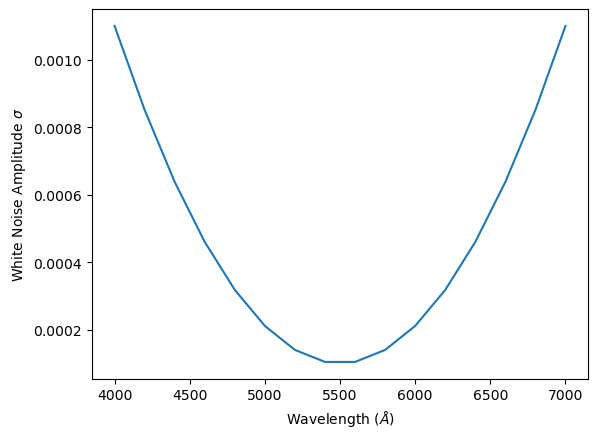

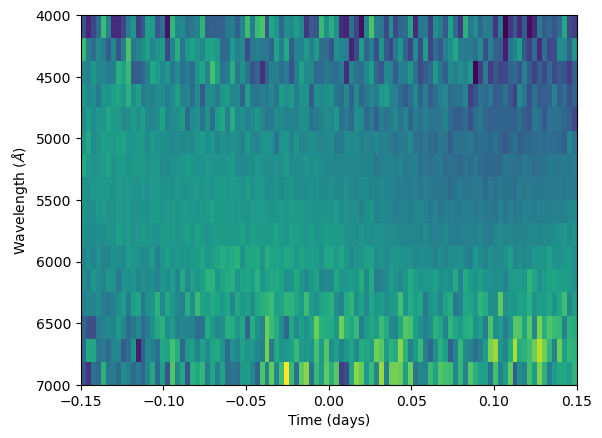

In [10]:
N_l = 16  # Number of wavelength channels
N_t = 100 # Number of time exposures

x_l = np.linspace(4000, 7000, N_l)  # Central wavelength of bins in angstrom
x_t = np.linspace(-0.15, 0.15, N_t) # Timestamps for our synthetic observations


Kl = kf(x_l, x_l, [5e-4, 1000], wn=False)
Kt = kf(x_t, x_t, [1., 0.1], wn=False)

# Generate correlated noise with small white noise added for numerical stability
r_2D = generate_noise(Kl, Kt, 1e-8)


wn_amp = (x_l - x_l.mean())**2
wn_amp /= wn_amp.max()
wn_amp = 1e-4*(1 + 10*wn_amp)

plt.plot(x_l, wn_amp)
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("White Noise Amplitude $\sigma$")
plt.show()

R = make_mat(r_2D, N_l, N_t)

wn = np.random.normal(size = (N_l, N_t))
R += np.diag(wn_amp) @ wn

plt.imshow(R, aspect = "auto", extent = [x_t[0], x_t[-1], x_l[-1], x_l[0]])
plt.xlabel("Time (days)")
plt.ylabel("Wavelength ($\AA$)")
plt.show()

We now implement a method first introduced in Rakitsch et al. (2013). It is similar to the method from Saatchi (2011) but involves an additional linear transformation. We can solve for the log-likelihood for a more general case of a covariance matrix of the form:

\begin{equation}
    \mathbf{K} = \mathbf{K}_\mathrm{\lambda} \otimes \mathbf{K}_\mathrm{t} + \mathbf{\Sigma}_\mathrm{\lambda} \otimes \mathbf{\Sigma}_\mathrm{t}
\end{equation}

Here we can keep using $K_\lambda$ and $K_t$ to describe the correlated noise and use the $\Sigma_\lambda$ and $\Sigma_t$ to account for the wavelength-dependent white noise.

We start by computing the eigendecomposition of the $\Sigma_\lambda$ and $\Sigma_t$ matrices (if these matrices are diagonal then this is trivial to compute):

\begin{align}
        \mathbf{\Sigma}_\mathrm{\lambda} &= \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}} \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}} \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}}^T \\
        \mathbf{\Sigma}_\mathrm{t} &= \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{t}} \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{t}} \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{t}}^T
    \end{align}
    
We then transform the $K_\lambda$ and $K_t$ matrices using this eigendecomposition:

\begin{align}
        \tilde{\mathbf{K}}_\mathrm{\lambda} &= \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}}^{-\frac{1}{2}} \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}}^T \mathbf{K}_\mathrm{\lambda} \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}} \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}}^{-\frac{1}{2}} \\
        \tilde{\mathbf{K}}_\mathrm{t} &= \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{t}}^{-\frac{1}{2}} \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{t}}^T \mathbf{K}_\mathrm{t} \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{t}} \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{t}}^{-\frac{1}{2}}
    \end{align}
    
We then compute the eigendecomposition of both of these transformed matrices. We can now write the matrix $\mathbf{K}$ as a product of three terms. Multiplying this product out should show it is equal to $\mathbf{K}$.

\begin{equation}
    \mathbf{K} = [\mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}} \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}}^{\frac{1}{2}} \otimes \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{t}} \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{t}}^{\frac{1}{2}}] [\tilde{\mathbf{K}}_\mathrm{\lambda} \otimes \tilde{\mathbf{K}}_\mathrm{t} + \mathbb{I}_\mathrm{MN}] [\mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}}^{\frac{1}{2}} \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}}^T \otimes \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{t}}^{\frac{1}{2}} \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{t}}^T]
\end{equation}

Writing $\mathbf{K}$ in this way how to calculate the inverse of $\mathbf{K}$:

\begin{equation}
    \mathbf{K}^{-1} = [\mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}} \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}}^{-\frac{1}{2}} \otimes \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{t}} \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{t}}^{-\frac{1}{2}}] [\tilde{\mathbf{K}}_\mathrm{\lambda} \otimes \tilde{\mathbf{K}}_\mathrm{t} + \mathbb{I}]^{-1} [\mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}}^{-\frac{1}{2}} \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}}^T \otimes \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{t}}^{-\frac{1}{2}} \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{t}}^T]
\end{equation}

Notice how the middle term is of the same form as the matrices the Saatchi method can solve for. We can rewrite this middle term as:

\begin{equation}
[\tilde{\mathbf{K}}_\mathrm{\lambda} \otimes \tilde{\mathbf{K}}_\mathrm{t} + \mathbb{I}]^{-1} = [\mathbf{Q_\mathrm{\tilde{K}_\mathrm{\lambda}}} \otimes \mathbf{Q_\mathrm{\tilde{K}_\mathrm{t}}}] [\mathbf{\Lambda_\mathrm{\tilde{K}_\mathrm{\lambda}}} \otimes \mathbf{\Lambda_\mathrm{\tilde{K}_\mathrm{t}}} + \mathbb{I}]^{-1} [\mathbf{Q^T_\mathrm{\tilde{K}_\mathrm{\lambda}}} \otimes \mathbf{Q^T_\mathrm{\tilde{K}_\mathrm{t}}}]
\end{equation}

Plugging this in and rearranging, we have:

\begin{align}
    \mathbf{K}^{-1} &= [\mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}} \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}}^{-\frac{1}{2}} \mathbf{Q_\mathrm{\tilde{K}_\mathrm{\lambda}}} \otimes \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{t}} \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{t}}^{-\frac{1}{2}} \mathbf{Q_\mathrm{\tilde{K}_\mathrm{t}}}] [\mathbf{\Lambda_\mathrm{\tilde{K}_\mathrm{\lambda}}} \otimes \mathbf{\Lambda_\mathrm{\tilde{K}_\mathrm{t}}} + \mathbb{I}]^{-1} [\mathbf{Q^T_\mathrm{\tilde{K}_\mathrm{\lambda}}} \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}}^{-\frac{1}{2}} \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}}^T \otimes \mathbf{Q^T_\mathrm{\tilde{K}_\mathrm{t}}} \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{t}}^{-\frac{1}{2}} \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{t}}^T] \\
    &= [{\mathbf{W}}_\mathrm{\lambda} \otimes \mathbf{W}_\mathrm{t}] \mathbf{D}^{-1} [\mathbf{W^T_\mathrm{\lambda}} \otimes \mathbf{W^T_\mathrm{t}}]
\end{align}

Where:
\begin{align*}
    \mathbf{W}_\mathrm{\lambda} &= \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}} \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}}^{-\frac{1}{2}} \mathbf{Q_\mathrm{\tilde{K}_\mathrm{\lambda}}} \\
    \mathbf{W}_\mathrm{t} &= \mathbf{Q}_\mathrm{\mathbf{\Sigma}_\mathrm{t}} \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{t}}^{-\frac{1}{2}} \mathbf{Q_\mathrm{\tilde{K}_\mathrm{t}}}\\
    \mathbf{D} &= \mathbf{\Lambda_\mathrm{\tilde{K}_\mathrm{\lambda}}} \otimes \mathbf{\Lambda_\mathrm{\tilde{K}_\mathrm{t}}} + \mathbb{I}\\
\end{align*}

Note that $\mathbf{W}_\mathrm{\lambda}$ and $\mathbf{W}_\mathrm{t}$ are not actually the eigenvector matrices of $\mathbf{K}$ and in general are not even orthogonal. Similarly, the matrix $D$ does not in general contain the eigenvalues of $\mathbf{K}$ (although it is diagonal). The method nonetheless allows us to efficiently compute the exact value of $\mathbf{K}^{-1} \vec{r}$.

It can also be shown that the log-determinant of $\mathbf{K}$ is given by:

\begin{equation}\label{eq:logdet2}
        \log|\mathbf{K}| =  \sum_{i=1}^{MN} \log((\mathbf{\Lambda}_\mathrm{\tilde{\mathbf{K}}_\mathrm{\lambda}} \otimes \mathbf{\Lambda}_\mathrm{\tilde{\mathbf{K}}_\mathrm{t}})_{ii} + 1) + \log((\mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{\lambda}} \otimes \mathbf{\Lambda}_\mathrm{\mathbf{\Sigma}_\mathrm{t}})_{ii})
    \end{equation}
    
We now have an accurate way to calculate the log-likelihood for the above noise which has a varying white noise amplitude:

In [11]:
def eigendecompose_K(Kl, Kt, Sl, St):
    
    # First eigendecompose Sigma matrices
    lam_Sl, Q_Sl = np.linalg.eigh(Sl)
    lam_St, Q_St = np.linalg.eigh(St)
    
    # Need inverse sqrt of eigenvalues
    lam_Sl_sqrt = np.reciprocal(np.sqrt(lam_Sl))
    lam_St_sqrt = np.reciprocal(np.sqrt(lam_St))
    
    # Convert to diagonal matrices
    Lam_Sl_sqrt_inv = np.diag(lam_Sl_sqrt)
    Lam_St_sqrt_inv = np.diag(lam_St_sqrt)
    
    # Will use these to transform Kl and Kt
    Q_Lam_sqrt_inv_Sl = Q_Sl @ Lam_Sl_sqrt_inv
    Q_Lam_sqrt_inv_St = Q_St @ Lam_St_sqrt_inv
    
    # Perform transformation
    Kl_transf = Q_Lam_sqrt_inv_Sl.T @ Kl @ Q_Lam_sqrt_inv_Sl
    Kt_transf = Q_Lam_sqrt_inv_St.T @ Kt @ Q_Lam_sqrt_inv_St
    
    # Eigendecompose these transformed matrices
    lam_Kl_transf, Q_Kl_transf = np.linalg.eigh(Kl_transf)
    lam_Kt_transf, Q_Kt_transf = np.linalg.eigh(Kt_transf)
    
    # Form the outer "W" matrices which describe K^-1
    W_l = Q_Lam_sqrt_inv_Sl @ Q_Kl_transf
    W_t = Q_Lam_sqrt_inv_St @ Q_Kt_transf
    
    # Calculate the inner diagonal matrix of K^-1
    D = np.outer(lam_Kl_transf, lam_Kt_transf) + 1.
    D_inv = np.reciprocal(D)
    
    LogdetS = np.outer(lam_Sl, lam_St)
    logdetK = np.log(D).sum() + np.log(LogdetS).sum()

    return W_l, W_t, D_inv, logdetK


def logL_Rakitsch(r, Kl, Kt, Sl, St):
    
    
    # Form the outer "W" matrices which describe K^-1
    W_l, W_t, D_inv, logdetK = eigendecompose_K(Kl, Kt, Sl, St)
    
    # Convert R from a vector to a (wavelength x time) matrix
    R = make_mat(r, Kl.shape[0], Kt.shape[0])

    # Compute r^T K^-1 r
    alpha1 = kron_prod(W_l.T, W_t.T, R)
    alpha2 = np.multiply(D_inv, alpha1)
    r_K_inv_r = np.multiply(alpha1, alpha2).sum()

    logL = - 0.5*r_K_inv_r - 0.5*logdetK - 0.5*R.size*np.log(2*np.pi)
    
    return logL


N_l = 16 # Number of wavelength channels
N_t = 100 # Number of time exposures

x_l = np.linspace(4000, 7000, N_l)  # Central wavelength of bins in angstrom
x_t = np.linspace(-0.15, 0.15, N_t) # Timestamps for our synthetic observations


Kl = kf(x_l, x_l, [5e-4, 1000], wn=False)
Kt = kf(x_t, x_t, [1., 0.1], wn=False)

Sl = np.diag(wn_amp**2)
St = np.eye(N_t)

print("Log-likelihood using Rakitsch method: ", logL_Rakitsch(r_2D, Kl, Kt, Sl, St))

K_2D = np.kron(Kl, Kt) + np.kron(Sl, St)
print("Log-likelihood using Cholesky method: " , logL_cholesky(r_2D, K_2D))

Log-likelihood using Rakitsch method:  10393.159392499816
Log-likelihood using Cholesky method:  10393.159392499816


We can use a similar method as before to generate noise for any covariance matrix fitting this kernel function. Feel free to test how the runtime compares between the Cholesky and Rakitsch methods for different data set sizes. Large synthetic data sets may cause the program to crash however, note that if the product $NM > 32,768$ then the matrix $\mathbf{K}$ will require more than 8GB of memory to be stored. Commenting out the calculation of $\mathbf{K}$ and the Cholesky factorisation shows how large the data sets the Rakitsch method can be used for.

In [13]:
def generate_noise_kronsum(Kl, Kt, Sl, St):
    c = 1e-6**2
    
    Lam_Kl, Q_Kl = np.linalg.eigh(Kl)
    Lam_Kt, Q_Kt = np.linalg.eigh(Kt)
    
    Lam_mat_K = np.outer(Lam_Kl, Lam_Kt) + c
    Lam_mat_sqrt_K = np.sqrt(Lam_mat_K)
    
    Lam_Sl, Q_Sl = np.linalg.eigh(Sl)
    Lam_St, Q_St = np.linalg.eigh(St)
    
    Lam_mat_S = np.outer(Lam_Sl, Lam_St) - c
    Lam_mat_sqrt_S = np.sqrt(Lam_mat_S)
    
    z = np.random.normal(size = (Kl.shape[0], Kt.shape[0], 2))
    
    Lam_z1 = np.multiply(Lam_mat_sqrt_K, z[:, :, 0])
    R = kron_prod(Q_Kl, Q_Kt, Lam_z1)
    
    Lam_z2 = np.multiply(Lam_mat_sqrt_S, z[:, :, 1])
    R += kron_prod(Q_Sl, Q_St, Lam_z2)
    
    return make_vec(R)


def generate_covariance_matrices(N_l, N_t):
    x_l = np.linspace(4000, 7000, N_l)  # Central wavelength of bins in angstrom
    x_t = np.linspace(-0.15, 0.15, N_t) # Timestamps for our synthetic observations

    Kl = kf(x_l, x_l, hp_dict["Kl"], wn=False)
    Kt = kf(x_t, x_t, hp_dict["Kt"], wn=False)
    Sl = kf(x_l, x_l, hp_dict["Sl"], wn=False)
    Sl = Sl + np.diag(hp_dict["wn"]**2)
    St = np.eye(x_t.size)
    
    return Kl, Kt, Sl, St

N_l = 64 # Number of wavelength channels
N_t = 100 # Number of time exposures

x_l = np.linspace(4000, 7000, N_l)  # Central wavelength of bins in angstrom
x_t = np.linspace(-0.15, 0.15, N_t) # Timestamps for our synthetic observations

wn_amp = (x_l - x_l.mean())**2
wn_amp /= wn_amp.max()
wn_amp = 1e-4*(1 + 10*wn_amp)

hp_dict = {"Kl":[5e-4, 1000.], "Kt":[1., 0.1], "Sl":[0., 1000.], "wn":wn_amp}

Kl, Kt, Sl, St = generate_covariance_matrices(N_l, N_t)

Kl = kf(x_l, x_l, [5e-4, 1000], wn=False)
Kt = kf(x_t, x_t, [1., 0.1], wn=False)

Sl = np.diag(np.random.uniform(1e-4, 1e-3, size = N_l)**2)
St = np.eye(N_t)

K_2D = np.kron(Kl, Kt) + np.kron(Sl, St)
r_2D = generate_noise_kronsum(Kl, Kt, Sl, St)

%timeit logL_Rakitsch(r_2D, Kl, Kt, Sl, St)
%timeit logL_cholesky(r_2D, K_2D)

3.62 ms ± 578 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
654 ms ± 7.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


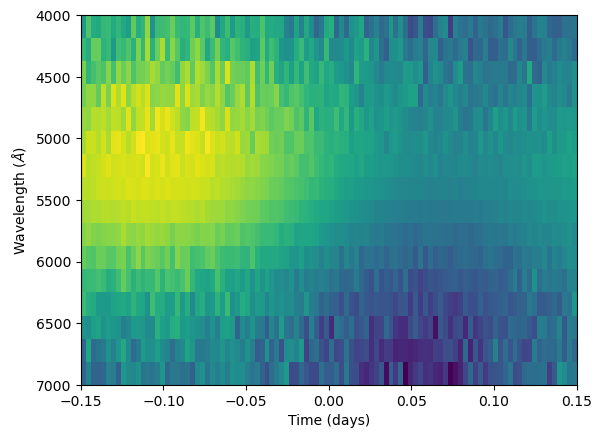

In [14]:
N_l = 16 # Number of wavelength channels
N_t = 100 # Number of time exposures

x_l = np.linspace(4000, 7000, N_l)  # Central wavelength of bins in angstrom
x_t = np.linspace(-0.15, 0.15, N_t) # Timestamps for our synthetic observations


Kl = kf(x_l, x_l, [5e-4, 1000], wn=False)
Kt = kf(x_t, x_t, [1., 0.1], wn=False)

wn_amp = (x_l - x_l.mean())**2
wn_amp /= wn_amp.max()
wn_amp = 1e-4**2*(0.01 + 10*wn_amp)
Sl = np.diag(wn_amp)
St = np.eye(N_t)


r_2D = generate_noise_kronsum(Kl, Kt, Sl, St)

R = make_mat(r_2D, N_l, N_t)
plt.imshow(R, aspect = "auto", extent = [x_t[0], x_t[-1], x_l[-1], x_l[0]])
plt.xlabel("Time (days)")
plt.ylabel("Wavelength ($\AA$)")
plt.show()

That covers the calculation of the log-likelihood function for this tutorial. The rest of this tutorial covers the optimisations to calculate the predictive mean and covariance of a 2D GP of this form. For simplicity, we will just be calculating it for the same locations as the data is located at, although the equations here should work whenever both the input points and predictive points each lie on respective two-dimensional grids. This is useful for interpolation and cleaning outliers. We will only calculate the diagonal of the predictive covariance as the memory cost of storing the full covariance matrix scales as $\mathcal{O}(N^2 M^2)$.

\begin{eqnarray}\label{eq:gp_mean}
        \mathbb{E}[\vec{y}_*] & = & \vec{\mu}_* + \mathbf{K}_*^T \mathbf{K}^{-1} (\vec{y} - \vec{\mu}) \\
        \text{Var}[\vec{y}_*] & = & \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{K}_*
    \end{eqnarray}
    
The $\mathbf{K}_*$ matrices do not include white noise terms, if the $\mathbf{\Sigma_\mathrm{\lambda}}$ and $\mathbf{\Sigma_\mathrm{t}}$ matrices are just being used to store white noise terms then this simplifies this calculation. However, we will consider the more general case here where $\mathbf{\Sigma_\mathrm{\lambda}}$ and $\mathbf{\Sigma_\mathrm{t}}$ are also accounting for correlated noise (this is the case for the kernel function chosen to fit the VLT/FORS2 data in Fortune et al. 2023).

Computing the GP predictive mean requires the calculation of $\alpha = \mathbf{K}^{-1} \vec{r}$ which has already been covered for the log-likelihood. Since $\mathbf{K}_*^T$ is similar to $\mathbf{K}$ but without the white noise terms included then it will in the most general case be a sum of two kronecker products and so we can just compute:

\begin{align*}
    \mathbf{K}_* &= \mathbf{K}_\mathrm{\lambda_*} \otimes \mathbf{K}_\mathrm{t_*} + \mathbf{\Sigma}_\mathrm{\lambda_*} \otimes \mathbf{\Sigma}_\mathrm{t_*} \\
    \mathbf{K}_*^T \vec{\alpha} &= [\mathbf{K}_\mathrm{\lambda_*}^T \otimes \mathbf{K}_\mathrm{t_*}^T] \vec{\alpha} + [\mathbf{\Sigma}_\mathrm{\lambda_*}^T \otimes \mathbf{\Sigma}_\mathrm{t_*}^T] \vec{\alpha}
\end{align*}

Implementing just this GP mean calculation we have:

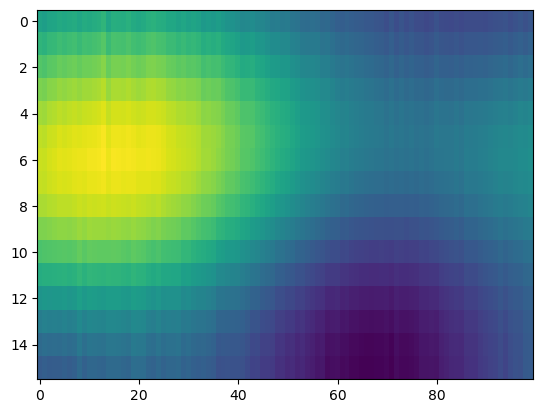

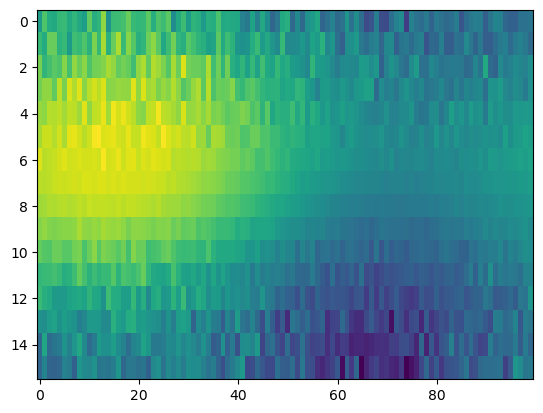

In [15]:
def K_inv_R(R, W_l, W_t, D_inv):
    alpha = kron_prod(W_l.T, W_t.T, R)
    alpha = np.multiply(D_inv, alpha)
    alpha = kron_prod(W_l, W_t, alpha)
    
    return alpha

def gp_predict_mean(R, x_l, x_l_s, x_t, x_t_s, hp_dict):
    Kl = kf(x_l, x_l, hp_dict["Kl"], wn=False)
    Kt = kf(x_t, x_t, hp_dict["Kt"], wn=False)
    Sl = kf(x_l, x_l, hp_dict["Sl"], wn=False)
    Sl = Sl + np.diag(hp_dict["wn"])
    St = np.eye(x_t.size)
    
    Kl_s = kf(x_l, x_l_s, hp_dict["Kl"], wn=False)
    Kt_s = kf(x_t, x_t_s, hp_dict["Kt"], wn=False)
    Sl_s = kf(x_l, x_l_s, hp_dict["Sl"], wn=False)
    St_s = kf(x_t, x_t_s, [1., 1e-6], wn=False)
    
    W_l, W_t, D_inv, logdetK = eigendecompose_K(Kl, Kt, Sl, St)
    alpha = K_inv_R(R, W_l, W_t, D_inv)

    gp_mean = kron_prod(Kl_s.T, Kt_s.T, alpha)
    gp_mean += kron_prod(Sl_s.T, St_s.T, alpha)

    return gp_mean


N_l = 16 # Number of wavelength channels
N_t = 100 # Number of time exposures

x_l = np.linspace(4000, 7000, N_l)  # Central wavelength of bins in angstrom
x_t = np.linspace(-0.15, 0.15, N_t) # Timestamps for our synthetic observations


wn_amp = (x_l - x_l.mean())**2
wn_amp /= wn_amp.max()
wn_amp = 1e-4**2*(0.01 + 10*wn_amp)

x_l_s = x_l.copy()
x_t_s = x_t.copy()



hp_dict = {"Kl":[5e-4, 1000], "Kt":[1., 0.1], "Sl":[1e-4, 2000], "wn":wn_amp}
gp_mean = gp_predict_mean(R, x_l, x_l_s, x_t, x_t_s, hp_dict)

plt.imshow(gp_mean, aspect = 'auto')
plt.show()

plt.imshow(R, aspect = 'auto')
plt.show()

Calculating the diagonal of the predictive covariance is more complicated however. Due to how the diagonal operator propagates for kronecker products and the fact that it is linear, we can easily calculate the diagonal of the first term using:

\begin{align*}
    \mathbf{K}_{**} &= \mathbf{K}_\mathrm{\lambda_{**}} \otimes \mathbf{K}_\mathrm{t_{**}} + \mathbf{\Sigma}_\mathrm{\lambda_{**}} \otimes \mathbf{\Sigma}_\mathrm{t_{**}} \\
    diag(\mathbf{K}_{**}) &= [diag(\mathbf{K}_\mathrm{\lambda_{**}}) \otimes diag(\mathbf{K}_\mathrm{t_{**}})] + [diag(\mathbf{\Sigma}_\mathrm{\lambda_{**}}) \otimes diag(\mathbf{\Sigma}_\mathrm{t_{**}})]
\end{align*}

The diagonal of the second term is more complicated. First let's expand it out into kronecker product terms:

\begin{align*}
    \mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{K}_* &= [\mathbf{K}_\mathrm{\lambda_*}^T \otimes \mathbf{K}_\mathrm{t_*}^T + \mathbf{\Sigma}_\mathrm{\lambda_*}^T \otimes \mathbf{\Sigma}^T_\mathrm{t_*}] [{\mathbf{W}}_\mathrm{\lambda} \otimes \mathbf{W}_\mathrm{t}] \mathbf{D}^{-1} [\mathbf{W^T_\mathrm{\lambda}} \otimes \mathbf{W^T_\mathrm{t}}] [\mathbf{K}_\mathrm{\lambda_*} \otimes \mathbf{K}_\mathrm{t_*} + \mathbf{\Sigma}_\mathrm{\lambda_*} \otimes \mathbf{\Sigma}_\mathrm{t_*}] \\
    &= [\mathbf{K}_\mathrm{\lambda_*}^T {\mathbf{W}}_\mathrm{\lambda} \otimes \mathbf{K}_\mathrm{t_*}^T \mathbf{W}_\mathrm{t} + \mathbf{\Sigma}_\mathrm{\lambda_*}^T {\mathbf{W}}_\mathrm{\lambda} \otimes \mathbf{\Sigma}^T_\mathrm{t_*} \mathbf{W}_\mathrm{t}] \mathbf{D}^{-1} [\mathbf{W^T_\mathrm{\lambda}} \mathbf{K}_\mathrm{\lambda_*} \otimes \mathbf{W^T_\mathrm{t}} \mathbf{K}_\mathrm{t_*} + \mathbf{W^T_\mathrm{\lambda}} \mathbf{\Sigma}_\mathrm{\lambda_*} \otimes \mathbf{W^T_\mathrm{t}} \mathbf{\Sigma}_\mathrm{t_*}] \\
    &= [\mathbf{Y}_\mathrm{\lambda} \otimes \mathbf{Y}_\mathrm{t} + \mathbf{Z}_\mathrm{\lambda} \otimes \mathbf{Z}_\mathrm{t}] \mathbf{D}^{-1} [\mathbf{Y}_\mathrm{\lambda}^T \otimes \mathbf{Y}_\mathrm{t}^T + \mathbf{Z}_\mathrm{\lambda}^T \otimes \mathbf{Z}_\mathrm{t}^T]
\end{align*}

Where we have defined:
\begin{align*}
    \mathbf{Y}_\mathrm{\lambda} &= \mathbf{K}_\mathrm{\lambda_*}^T {\mathbf{W}}_\mathrm{\lambda} \\
    \mathbf{Y}_\mathrm{t} &= \mathbf{K}_\mathrm{t_*}^T {\mathbf{W}}_\mathrm{t} \\
    \mathbf{Z}_\mathrm{\lambda} &= \mathbf{\Sigma}_\mathrm{\lambda_*}^T {\mathbf{W}}_\mathrm{\lambda} \\
    \mathbf{Z}_\mathrm{t} &= \mathbf{\Sigma}_\mathrm{t_*}^T {\mathbf{W}}_\mathrm{t} \\
\end{align*}

We will use this simplified form of $\mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{K}_*$ later. We also want to see what happens when we take the diagonal of this term. Defining one more matrix $\mathbf{X}$ as:
\begin{equation}
    \mathbf{X} = \mathbf{Y}_\mathrm{\lambda} \otimes \mathbf{Y}_\mathrm{t} + \mathbf{Z}_\mathrm{\lambda} \otimes \mathbf{Z}_\mathrm{t}
\end{equation}

We want to find:

\begin{equation}
    diag(\mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{K}_*) = diag(\mathbf{X} \mathbf{D}^{-1} \mathbf{X}^T) 
\end{equation}

Switching to Einstein summation convention:

\begin{align}
    (\mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{K}_*)_{ij} &= X_{im} D^{-1}_{mn} X^T_{nj} \\
    &= X_{im} D^{-1}_{mn} X_{jn}
\end{align}

As $\mathbf{D}^{-1}$ is a diagonal matrix, it can be written as:

\begin{equation}
    \mathbf{D}^{-1}_{mn} = \delta_{mn} d^{-1}_n
\end{equation}

Plugging this in we get:
\begin{align}
    (\mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{K}_*)_{ij} &= X_{im} \delta_{mn} d^{-1}_n X_{jn} \\
    &= X_{im} d^{-1}_m X_{jm} \\
\end{align}

Finally as we want the diagonal elements of the matrix we can set $i = j$, producing:
\begin{align}
    (\mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{K}_*)_{ii} &= X_{im} d^{-1}_m X_{im} \\
\end{align}

Note that the term $X_{im}$ appears twice. If we first calculate the element-wise square of $\mathbf{X}$ then we can consider this as a simple matrix-vector product. Re-writing back into standard linear algebra notation and using the Hadamard product $\circ$ to denote element-wise multiplication we get:

\begin{equation}
    diag(\mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{K}_*) = (\mathbf{X} \circ \mathbf{X}) \vec{d^{-1}} \\
\end{equation}

Now that we have this simpler equation for the diagonal, we can look at calculating the element-wise square of $\mathbf{X}$. We have:

\begin{equation}
    \mathbf{X} \circ \mathbf{X} = [\mathbf{Y}_\mathrm{\lambda} \otimes \mathbf{Y}_\mathrm{t} + \mathbf{Z}_\mathrm{\lambda} \otimes \mathbf{Z}_\mathrm{t}] \circ [\mathbf{Y}_\mathrm{\lambda} \otimes \mathbf{Y}_\mathrm{t} + \mathbf{Z}_\mathrm{\lambda} \otimes \mathbf{Z}_\mathrm{t}]
\end{equation}

We make use of three properties of the Hadamard property. The first two are that it is linear and commutative, allowing us to expand this to:
\begin{equation}
    \mathbf{X} \circ \mathbf{X} = [\mathbf{Y}_\mathrm{\lambda} \otimes \mathbf{Y}_\mathrm{t}] \circ [\mathbf{Y}_\mathrm{\lambda} \otimes \mathbf{Y}_\mathrm{t}] + 2[\mathbf{Y}_\mathrm{\lambda} \otimes \mathbf{Y}_\mathrm{t}] \circ [\mathbf{Z}_\mathrm{\lambda} \otimes \mathbf{Z}_\mathrm{t}] + [\mathbf{Z}_\mathrm{\lambda} \otimes \mathbf{Z}_\mathrm{t}] \circ [\mathbf{Z}_\mathrm{\lambda} \otimes \mathbf{Z}_\mathrm{t}]
\end{equation}

Finally, the Hadamard property commutes with the kronecker product. This means we can write $\mathbf{X} \circ \mathbf{X}$ purely as a sum of kronecker products as:
\begin{equation}
    \mathbf{X} \circ \mathbf{X} = [\mathbf{Y}_\mathrm{\lambda} \circ \mathbf{Y}_\mathrm{\lambda}] \otimes [\mathbf{Y}_\mathrm{t} \circ \mathbf{Y}_\mathrm{t}] + 2[\mathbf{Y}_\mathrm{\lambda} \circ \mathbf{Z}_\mathrm{\lambda}] \otimes [\mathbf{Y}_\mathrm{t} \circ \mathbf{Z}_\mathrm{t}] + [\mathbf{Z}_\mathrm{\lambda} \circ \mathbf{Z}_\mathrm{\lambda}] \otimes [\mathbf{Z}_\mathrm{t} \circ \mathbf{Z}_\mathrm{t}]
\end{equation}

This allows us to calculate the diagonal of $\mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{K}_*$ using the sum of three matrix vector products, each of which can be efficiently computed in $\mathcal{O}(NM(N+M))$ time and $\mathcal{O}(N^2 + M^2)$ memory:

\begin{equation}
    diag(\mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{K}_*) = [\mathbf{Y}_\mathrm{\lambda} \circ \mathbf{Y}_\mathrm{\lambda}] \otimes [\mathbf{Y}_\mathrm{t} \circ \mathbf{Y}_\mathrm{t}] \vec{d^{-1}} + 2[\mathbf{Y}_\mathrm{\lambda} \circ \mathbf{Z}_\mathrm{\lambda}] \otimes [\mathbf{Y}_\mathrm{t} \circ \mathbf{Z}_\mathrm{t}] \vec{d^{-1}} + [\mathbf{Z}_\mathrm{\lambda} \circ \mathbf{Z}_\mathrm{\lambda}] \otimes [\mathbf{Z}_\mathrm{t} \circ \mathbf{Z}_\mathrm{t}] \vec{d^{-1}}
\end{equation}

If the $\mathbf{\Sigma_\mathrm{\lambda}}$ and $\mathbf{\Sigma_\mathrm{t}}$ are only being used to account for white noise then the $\mathbf{Z}$ matrices will be matrices of zeros and so this would simplify to a single matrix-vector product involving just the $\mathbf{Y}$ matrices.

Adding this covariance matrix calculation to the previous GP mean code, we have:

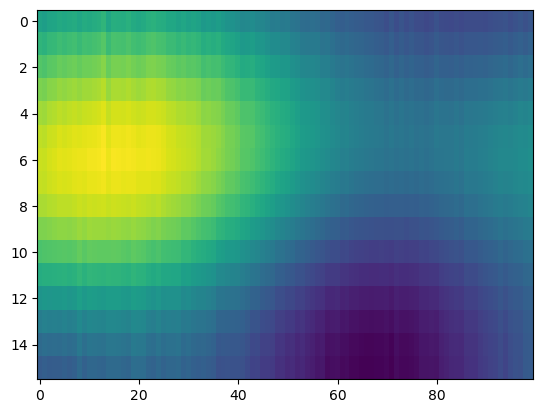

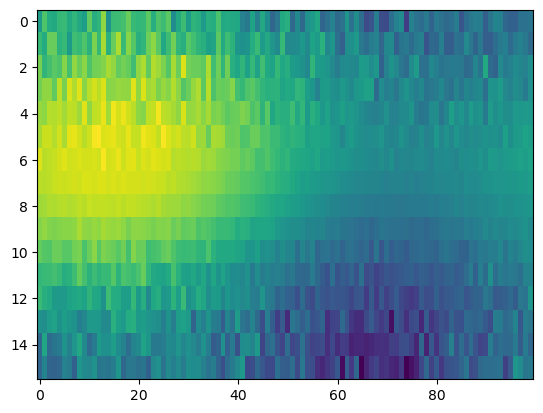

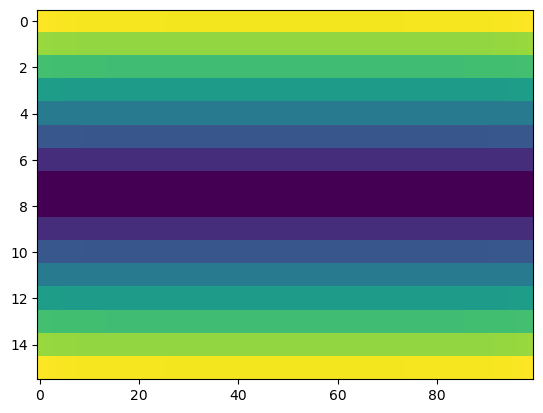

In [17]:
def gp_predict(R, x_l, x_l_s, x_t, x_t_s, hp_dict):
    Kl = kf(x_l, x_l, hp_dict["Kl"], wn=False)
    Kt = kf(x_t, x_t, hp_dict["Kt"], wn=False)
    Sl = kf(x_l, x_l, hp_dict["Sl"], wn=False)
    Sl = Sl + np.diag(hp_dict["wn"])
    St = np.eye(x_t.size)
    
    Kl_s = kf(x_l, x_l_s, hp_dict["Kl"], wn=False)
    Kt_s = kf(x_t, x_t_s, hp_dict["Kt"], wn=False)
    Sl_s = kf(x_l, x_l_s, hp_dict["Sl"], wn=False)
    St_s = kf(x_t, x_t_s, [1., 1e-6], wn=False)
    
    Kl_ss = kf(x_l_s, x_l_s, hp_dict["Kl"], wn=False)
    Kt_ss = kf(x_t_s, x_t_s, hp_dict["Kt"], wn=False)
    Sl_ss = kf(x_l_s, x_l_s, hp_dict["Sl"], wn=False)
    Sl_ss = Sl_ss + np.diag(np.interp(x_l_s, x_l, hp_dict["wn"]))
    St_ss = np.eye(x_t_s.size)
    
    W_l, W_t, D_inv, logdetK = eigendecompose_K(Kl, Kt, Sl, St)
    alpha = K_inv_R(R, W_l, W_t, D_inv)

    gp_mean = kron_prod(Kl_s.T, Kt_s.T, alpha)
    gp_mean += kron_prod(Sl_s.T, St_s.T, alpha)
    
    Y_l = Kl_s.T @ W_l
    Y_t = Kt_s.T @ W_t
    Z_l = Sl_s.T @ W_l
    Z_t = St_s.T @ W_t
    
    sigma_diag = np.outer(np.diag(Kl_ss), np.diag(Kt_ss))
    sigma_diag += np.outer(np.diag(Sl_ss), np.diag(St_ss))

    sigma_diag -= kron_prod(Y_l**2, Y_t**2, D_inv)
    sigma_diag -= kron_prod(Z_l**2, Z_t**2, D_inv)
    sigma_diag -= 2*kron_prod(Y_l * Z_l, Y_t * Z_t, D_inv)
    
    return gp_mean, np.sqrt(sigma_diag)


N_l = 16 # Number of wavelength channels
N_t = 100 # Number of time exposures

x_l = np.linspace(4000, 7000, N_l)  # Central wavelength of bins in angstrom
x_t = np.linspace(-0.15, 0.15, N_t) # Timestamps for our synthetic observations


wn_amp = (x_l - x_l.mean())**2
wn_amp /= wn_amp.max()
wn_amp = 1e-4**2*(0.01 + 10*wn_amp)

x_l_s = x_l.copy()
x_t_s = x_t.copy()



hp_dict = {"Kl":[5e-4, 1000], "Kt":[1., 0.1], "Sl":[1e-4, 2000], "wn":wn_amp}
gp_mean, sigma_diag = gp_predict(R, x_l, x_l_s, x_t, x_t_s, hp_dict)

plt.imshow(gp_mean, aspect = 'auto')
plt.show()

plt.imshow(R, aspect = 'auto')
plt.show()
    
plt.imshow(sigma_diag, aspect = 'auto')
plt.show()